In [1]:
import xesmf as xe
import xarray as xr
import cartopy.crs as ccrs
import numpy as np
import matplotlib.pyplot as plt
import cmocean.cm as cm
from netCDF4 import Dataset
import urllib.request

In [2]:
from dask_jobqueue import SLURMCluster  # setup dask cluster 
cluster = SLURMCluster(
    cores=4,
    processes=1,
    memory='5GB',
    walltime='02:00:00',
    queue='compute',
    interface='ib0')
cluster.scale(jobs=1)
from dask.distributed import Client
client = Client(cluster) #get task stream and progress

In [3]:
client

Connection method: Cluster object,Cluster type: dask_jobqueue.SLURMCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://172.16.3.73:46403,Workers: 0
Dashboard: /proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [18]:
era5_data_path = "/vortexfs1/share/cmip6/data/era5/reanalysis/single-levels/monthly-means/"

def preprocess(ds): 
    tmp = ds.resample(time="YE").mean() # where YE is for years
    # tmp = ds.resample(time="D").mean() # where YE is for years
    return tmp 
    
#10m u-wind
u10m = xr.open_mfdataset(era5_data_path + "10m_u_component_of_wind/*.nc", 
                         engine = "netcdf4", preprocess = preprocess)

#10m v-wind
v10m = xr.open_mfdataset(era5_data_path + "10m_v_component_of_wind/*.nc", 
                         engine = "netcdf4", preprocess = preprocess)

wind_ds = xr.merge([u10m, v10m], compat = "minimal") #minimal means I only want to merge the data that has the same coordinates

wind_ds["speed"] = np.sqrt(wind_ds["u10"]**2 + wind_ds["v10"]**2)

precip = xr.open_mfdataset(era5_data_path + "surface_pressure/*.nc", 
                         engine = "netcdf4", preprocess = preprocess)

In [20]:
precip_wind_correlations = xr.corr(precip["sp"], wind_ds["speed"], dim = "time")
precip_wind_correlations = precip_wind_correlations.compute()

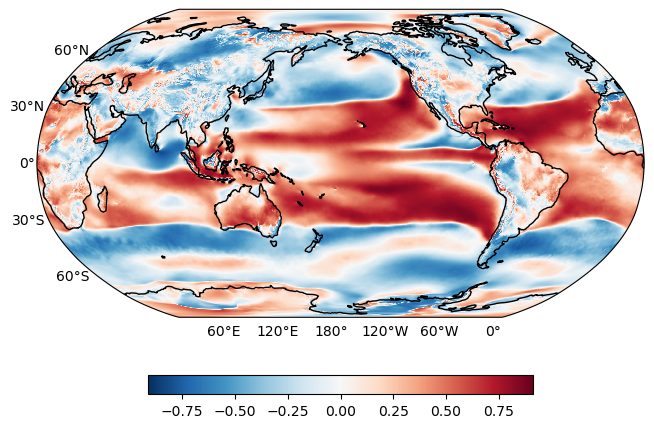

In [21]:
cbar_kwargs = dict(orientation = "horizontal", fraction = 0.05)
kwargs = dict(transform = ccrs.PlateCarree(), cbar_kwargs = cbar_kwargs)

fig, ax = plt.subplots(figsize=[20,5], subplot_kw={'projection':ccrs.Robinson(190)})
precip_wind_correlations.plot(ax=ax, **kwargs)
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, alpha=0.0, linestyle='--')
gl.top_labels = False
gl.right_labels = False

ax.coastlines()

In [ ]:
ds_locs = xr.Dataset()

ds_locs["lon"] = xr.DataArray(
    data=[-120], dims=("locations")
)
ds_locs["lat"] = xr.DataArray(data=[-20], dims=("locations"))

In [ ]:
fig, ax = plt.subplots(figsize=[20,5], subplot_kw={'projection':ccrs.Robinson(190)})
precip_wind_correlations.plot(ax=ax, **kwargs)
ax.scatter(ds_locs["lon"], ds_locs["lat"], transform = ccrs.PlateCarree(), s = 50, c = "k")
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, alpha=0.2, linestyle='--')
gl.top_labels = False
gl.right_labels = False
ax.coastlines()

In [23]:
regridder = xe.Regridder(wind_ds, ds_locs, "bilinear", locstream_out=True)
subsampled_wind_ds = regridder(wind_ds).compute()
subsampled_precip_ds = regridder(precip).compute()

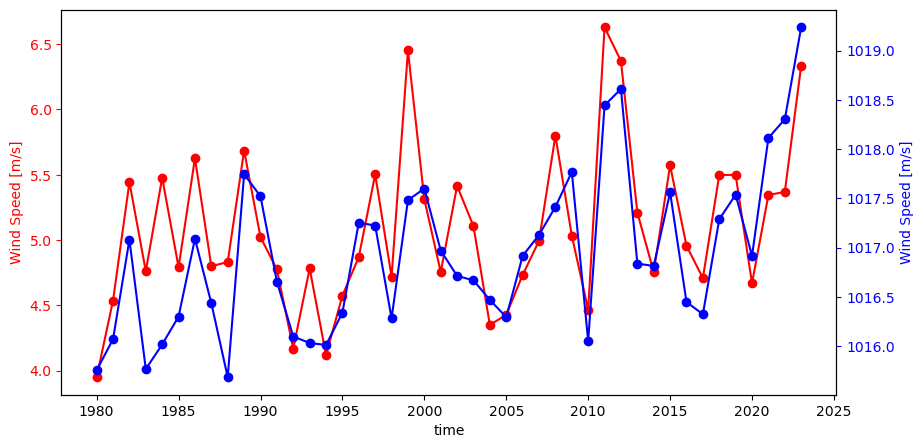

In [33]:
fig, ax = plt.subplots(figsize = (10, 5))

wind_speed = subsampled_wind_ds.speed
surface_pressure = subsampled_precip_ds.sp / 100 #Pa -> millibars
wind_speed.plot(ax = ax, c = "red", marker = "o")
ax.set_ylabel("Wind Speed [m/s]", c = "red")
ax.tick_params(axis='y', colors='red')

ax2 = ax.twinx()
surface_pressure.plot(ax = ax2, marker = "o", c = "b")
ax2.set_ylabel("Precipitation [m]")
ax2.set_ylabel("Wind Speed [m/s]", c = "b")
ax2.tick_params(axis='y', colors='b')